# Using R-peak as main fitting parameter
### We will now be:
1. Finding R peak (highest)
2. Fitting R peak
3. Finding the minimum left of R (aka Q), and fitting
4. Finding the maximum left of Q (aka P), and fitting
5. Finding minimum right of R (aka S), and fitting
6. Finding maxmimum right of S (aka T), and fitting

### Imports

In [1]:
import sys
print(sys.executable)
sys.path.append('..')

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd
import neurokit2 as nk
import numpy as np
import os

from src.gaussian_funcs import gaussian_function, compute_gauss_std, calc_r_squared
from src.utils import create_subject_file_mapping, extract_data, extract_metadata, compute_knee_frequency, compute_time_constant
from src.processing import simulate_ecg_signal, average_fft_of_epochs_loglog, extract_control_points, find_most_similar_signal, create_peak_params, get_peak_indices
from src.analysis import epoch_signals, find_extremum, estimate_fwhm, find_peak_boundaries, generate_histograms, calculate_sharpness_deriv

from scipy.signal import detrend, butter, filtfilt, welch
from scipy.optimize import curve_fit

#Not using these right now, but will re-implements eventually
# from fooof import FOOOF
# from src.acfs.conversions import convert_knee, psd_to_acf, acf_to_psd
# from src.utils import normalize
# from src.acfs.fit import ACF
# from src.acfs.conversions import convert_knee
# from src.autoreg import compute_ar_spectrum
# from timescales.plts import set_default_rc
# set_default_rc()


/Users/morganfitzgerald/miniconda3/envs/ecgenv/bin/python


In [2]:
import os

print("Current Working Directory:", os.getcwd())


Current Working Directory: /Users/morganfitzgerald/Projects/ecg_param/notebooks


### Global Attributes

In [3]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 5)

#FS = sampling rate; The sampling frequency of `ecg_signal` (in Hz, i.e., samples/second).
FS = 1000
fs = 1000
sampling_rate = 1000

CROP_MIN = 1000
CROP_MAX = 3000
WINDOW_LENGTH = 5000

FWHM_Q_IND = 5
FWHM_S_IND = 5
STD_R_HEIGHT = 10

PLOT = False

## Template matching

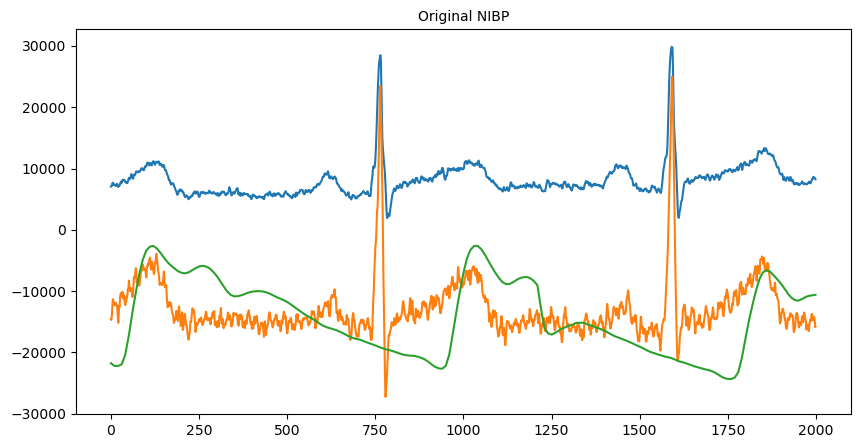

In [4]:
# Manual input of subject number as a string to match dictionary keys
SUB_NUM = '1'  # Ensure this matches the format of your subject numbers in the dictionary

# Code to select the ECG signal
dir_path = '/Users/morganfitzgerald/Projects/ecg_param/data/raw'
files_dat_dict, files_hea_dict = create_subject_file_mapping(dir_path)

# Extract single subject
if SUB_NUM in files_dat_dict and SUB_NUM in files_hea_dict:
    sigs, metadata = extract_data(
        files_dat_dict[SUB_NUM],
        files_hea_dict[SUB_NUM],
        raw_dtype='int16'
    )
else:
    print(f"Subject number {SUB_NUM} not found.")
    
# Iterate through signals and plot only the original signals
for ind in range(metadata['n_sigs']):

    #plt.figure(figsize=(12, 2))

    # Original signal
    signal_name = metadata[f'sig{str(ind).zfill(2)}']['signal_name']
    original_signal = sigs[ind][CROP_MIN:CROP_MAX]
    
    plt.plot(original_signal)
    plt.title(f'Original {signal_name}', size=10)

plt.show()

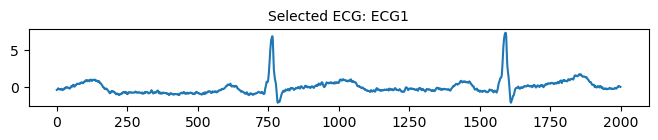

In [5]:
#SELECT THE SIGNAL
# Template ECG signal
template_ecg = simulate_ecg_signal(duration=5, sampling_rate=1000, heart_rate=80, amplitude_factor=7, normalize=False)

# List to store normalized signals
#Must normalize or the diff amplitudes mess up signal selection
normalized_signals = []

# Iterate through signals and normalize each
for ind in range(metadata['n_sigs']):
    signal_name = metadata[f'sig{str(ind).zfill(2)}']['signal_name']

    if signal_name == 'NIBP': 
        continue
    
    # Cut the signal shorter before normalization
    cropped_signal = sigs[ind][CROP_MIN:CROP_MAX]

    # Normalize the signal
    normalized_signal = (cropped_signal - np.mean(cropped_signal)) / np.std(cropped_signal)

    # Add normalized signal to the list

    normalized_signals.append(normalized_signal)

   #plt.plot(normalized_signal)

# Find the most similar signal to the template using cross-correlation
selected_signal, selected_signal_name, selected_signal_index = find_most_similar_signal(template_ecg, normalized_signals, metadata)

# Plot the most similar signal with the original signal name in the title
plt.figure(figsize=(8, 1))
plt.plot(selected_signal)
# plt.plot(template_ecg)
plt.title(f'Selected ECG: {selected_signal_name}', size=10)
plt.show()

# Now 'ecg' contains the selected signal
ecg = sigs[selected_signal_index]


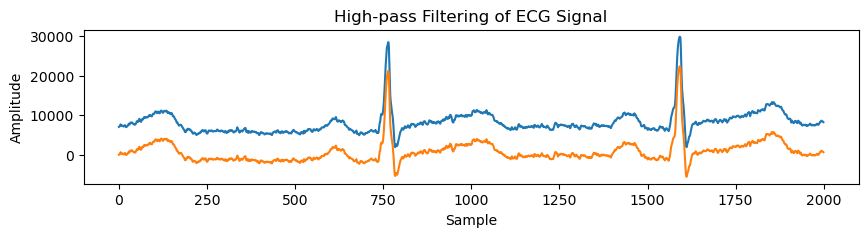

In [6]:
#Filtering
# Define the high-pass filter parameters
cutoff_frequency = 0.05  # Set your desired cutoff frequency in Hz
order = 4  # Set the filter order

# Design the high-pass filter
b, a = butter(order, cutoff_frequency, btype='high', analog=False, fs=metadata['fs'])

# Apply the high-pass filter to the ECG signal
ecg_hp = filtfilt(b, a, ecg)

# Plot the original and filtered signals
plt.figure(figsize=(10, 2))
plt.plot(ecg[CROP_MIN:CROP_MAX], label='Original ECG')
plt.plot(ecg_hp[CROP_MIN:CROP_MAX], label=f'High-pass Filtered ECG (Cutoff: {cutoff_frequency} Hz)')
plt.title('High-pass Filtering of ECG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
# plt.legend()
plt.show()



#### Notch filtering

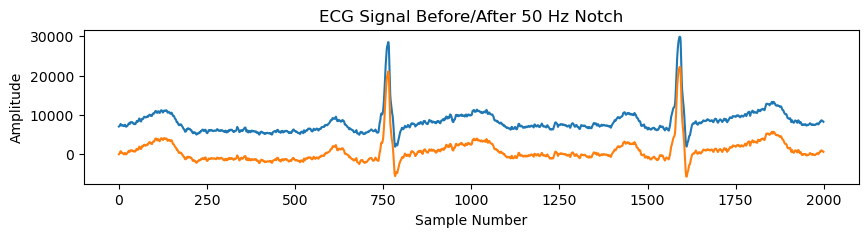

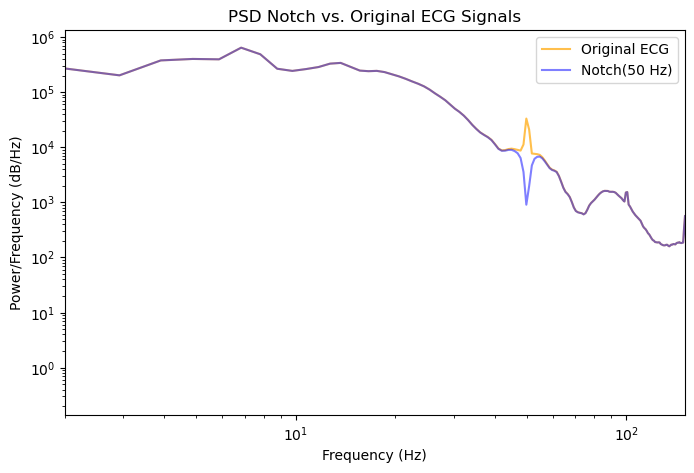

In [7]:
from scipy.signal import iirnotch, filtfilt
# import matplotlib.pyplot as plt
# import numpy as np

# Assuming 'ecg' is your ECG signal, 'fs' is the sampling rate
fs = metadata['fs']  # Sampling rate
f0 = 50  # Line noise frequency (50 Hz)
quality_factor = 30  # Quality factor, determines bandwidth around f0

# Design the bandstop (notch) filter
b, a = iirnotch(f0, quality_factor, fs)

# Apply the filter
ecg_notch = filtfilt(b, a, ecg_hp)

# Plotting
plt.figure(figsize=(10, 2))
plt.plot(ecg[CROP_MIN:CROP_MAX], label='Original ECG')
plt.plot(ecg_notch[CROP_MIN:CROP_MAX], label=f'High-pass Filtered ECG (Cutoff: {cutoff_frequency} Hz)')
plt.title('ECG Signal Before/After 50 Hz Notch')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
# plt.legend()
plt.show()

# Compute the PSD using Welch's method for the original ECG
f_original, Pxx_original = welch(ecg, fs, nperseg=1024)

# Compute the PSD using Welch's method for the ecg_notch filtered ECG
f_notch, Pxx_notch = welch(ecg_notch, fs, nperseg=1024)

# Plot the PSD for the original and high-pass filtered ECG signals
plt.figure(figsize=(8, 5))
# # Plot for original ECG signal
plt.loglog(f_original, Pxx_original, label='Original ECG', color = 'orange', alpha = 0.7)
# Plot for high-pass filtered ECG signal
plt.loglog(f_notch, Pxx_notch, label=f'Notch(50 Hz)', alpha = 0.5, color = 'blue')
plt.title('PSD Notch vs. Original ECG Signals')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.xlim([2, 150])  # Limit x-axis to 2-150 Hz
plt.legend()
plt.show()

## Neurokit Cleaning

- Here we are using neurokit's cleaning methods to extract a P onset value in the time domain. 
- Subsequently, we take this onset value and epoch our 'more raw' signal to preserve shape. 


In [8]:
ecg_clean_nk = nk.ecg_clean(ecg, sampling_rate=1000)
p_peaks_nk, rpeaks_nk, waves_nk = extract_control_points(ecg_clean_nk, sampling_rate)

# epochs_nk_df, _ = epoch_signals(p_peaks_nk, ecg_clean_nk, FS, SUB_NUM, PLOT = False, SAVE = False)

## Epoch 

* Here we are identifying the P Onset values and alignign all the signals to their P Onset (+200 ms buffer). This enables us to visualize R peak and overal cycle variability to a greater degree than Neurokits default centering at the R peaks. 


<Figure size 1000x500 with 0 Axes>

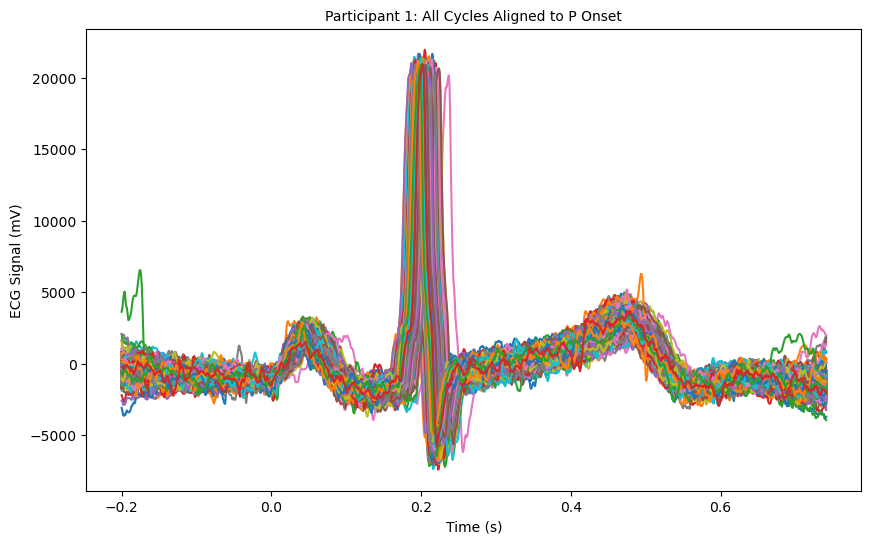

In [9]:
# Call the epoch functoin
epochs_df, result_r_latencies = epoch_signals(p_peaks_nk, ecg_notch,FS, SUB_NUM,  PLOT = True, SAVE = False)

## PSD and Fit from SpecParam

In [11]:
# ##FFT Signal
# avg_freq, avg_magnitude = average_fft_of_epochs_loglog(epochs_df, sampling_rate = 1000, PLOT=False)

In [12]:
# # Set the frequency range to fit the model
# freq_range = [2, 200]

# # Define columns for the DataFrame based on your results dictionary
# columns = ['SUB_NUM', 'Offset', 'Exponent', 'Error', 'R^2']
# specparam_results = pd.DataFrame(columns=columns)

# # Initialize a FOOOF object
# fm = FOOOF(aperiodic_mode='fixed', verbose=False, max_n_peaks=10)

# # Fit the model to the data
# fm.fit(avg_freq, avg_magnitude, freq_range)

# # # Report: fit the model, print the resulting parameters, and plot the reconstruction
# fm.report(avg_freq, avg_magnitude, freq_range)

# offset = fm.aperiodic_params_[0]  # Assuming first element is offset
# exponent = fm.aperiodic_params_[1]  # Assuming third element is exponent
# error = fm.error_
# r_squared = fm.r_squared_

# # Create a dictionary with this data
# specparam_data = {
#     'SUB_NUM': SUB_NUM,
#     'Offset_sp': [offset],
#     'Exponent_sp': [exponent],
#     'Error_sp': [error],
#     'R^2_sp': [r_squared]
# }

# specparam_results = pd.DataFrame(specparam_data)

# #Save output in new file 
# specparam_results.to_csv(f'../docs/saved_files/spectral_results/{SUB_NUM}_specparam_results.csv')


# PARAMETERIZATION: Fit Gaussians

In [23]:
# Number of unique cycles
num_cycles = len(epochs_df['cycle'].unique())

ecg_output_dict = {
    "cycle": np.arange(0, num_cycles).tolist(),
    "p_center": [np.nan] * num_cycles,
    "p_height": [np.nan] * num_cycles,
    "p_width": [np.nan] * num_cycles,
    "q_center": [np.nan] * num_cycles,
    "q_height": [np.nan] * num_cycles,
    "q_width": [np.nan] * num_cycles,
    "r_center": [np.nan] * num_cycles,
    "r_height": [np.nan] * num_cycles,
    "r_width": [np.nan] * num_cycles,
    "s_center": [np.nan] * num_cycles,
    "s_height": [np.nan] * num_cycles,
    "s_width": [np.nan] * num_cycles,
    "t_center": [np.nan] * num_cycles,
    "t_height": [np.nan] * num_cycles,
    "t_width": [np.nan] * num_cycles,
    "r_squared": [np.nan] * num_cycles,
    "pr_interval": [np.nan] * num_cycles,
    "pr_segment": [np.nan] * num_cycles,
    "qrs_duration": [np.nan] * num_cycles,
    "st_segment": [np.nan] * num_cycles,
    "qt_interval": [np.nan] * num_cycles,
    "p_duration": [np.nan] * num_cycles,
    "pp_interval": [np.nan] * num_cycles,
    "rr_interval": [np.nan] * num_cycles,
    "fwhm_p": [np.nan] * num_cycles,
    "rise_time_p": [np.nan] * num_cycles,
    "decay_time_p": [np.nan] * num_cycles,
    "rise_decay_symmetry_p": [np.nan] * num_cycles,
    "sharpness_deriv_p": [np.nan] * num_cycles,
    "sharpness_diff_p": [np.nan] * num_cycles,
    "fwhm_q": [np.nan] * num_cycles,
    "rise_time_q": [np.nan] * num_cycles,
    "decay_time_q": [np.nan] * num_cycles,
    "rise_decay_symmetry_q": [np.nan] * num_cycles,
    "sharpness_deriv_q": [np.nan] * num_cycles,
    "sharpness_diff_q": [np.nan] * num_cycles,
    "fwhm_r": [np.nan] * num_cycles,
    "rise_time_r": [np.nan] * num_cycles,
    "decay_time_r": [np.nan] * num_cycles,
    "rise_decay_symmetry_r": [np.nan] * num_cycles,
    "sharpness_deriv_r": [np.nan] * num_cycles,
    "sharpness_diff_r": [np.nan] * num_cycles,
    "fwhm_s": [np.nan] * num_cycles,
    "rise_time_s": [np.nan] * num_cycles,
    "decay_time_s": [np.nan] * num_cycles,
    "rise_decay_symmetry_s": [np.nan] * num_cycles,
    "sharpness_deriv_s": [np.nan] * num_cycles,
    "sharpness_diff_s": [np.nan] * num_cycles,
    "fwhm_t": [np.nan] * num_cycles,
    "rise_time_t": [np.nan] * num_cycles,
    "decay_time_t": [np.nan] * num_cycles,
    "rise_decay_symmetry_t": [np.nan] * num_cycles,
    "sharpness_deriv_t": [np.nan] * num_cycles,
    "sharpness_diff_t": [np.nan] * num_cycles,
    "Average_Heart_Rate": [np.nan] * num_cycles,
    "SDNN": [np.nan] * num_cycles,
    "RMSSD": [np.nan] * num_cycles,
    "NN50": [np.nan] * num_cycles,
}
# # # Display the dictionary
# ecg_output_dict

In [24]:
# Initialize variables to hold the previous peaks' locations
previous_r_center = None
previous_p_center = None

# Ensure on and off keys are initialized
#used to calculate various durations and intervals for the ECG components
for comp in ['p', 'q', 'r', 's', 't']:
    ecg_output_dict[f'{comp}_on'] = [np.nan] * num_cycles
    ecg_output_dict[f'{comp}_off'] = [np.nan] * num_cycles

# Isolate one subject at a time and build a for loop for fitting gaussians
    #len(epochs_df['cycle'].unique())
for cycle in np.arange(0, 20):
    print(f"Parameterizing cycle #{cycle}.")
    one_cycle = epochs_df.loc[epochs_df['cycle'] == cycle]
    if one_cycle.empty:
        print(f'cycle #{cycle} is empty')
        continue
    if one_cycle['signal_y'].isnull().values.any():
        print(f'cycle #{cycle} has NaNs')
        continue

    # X values and Y values with offset correction
    xs = np.arange(one_cycle['index'].iloc[0], one_cycle['index'].iloc[-1] + 1)
    sig = np.asarray(one_cycle['signal_y'])
    sig_flat = detrend(sig)
    sig = sig_flat - np.mean(sig_flat[0:25])
    

### GUESSES START #####
    ##### Defining R guesses first #####
    r_ind = np.argmax(sig)
    r_height = sig[r_ind]
    r_center = xs[r_ind]

    half_r_height = 0.5 * r_height

    #F_P_B: Find the indices for the onset (left) and offset (right) of a peak in a signal, based on the peak's height.
    le_ind_r, ri_ind_r = find_peak_boundaries(sig, r_ind, peak_height=r_height)

    # Use estimate_fwhm to calculate the FWHM based on the left and right indices
    fwhm_r = estimate_fwhm(le_ind_r, ri_ind_r, r_ind)

    # Check if FWHM calculation was successful
    if fwhm_r is None:
        print(f"Cycle #{cycle} could not estimate FWHM.")
        continue

    # #### Now define rest of component guesses ####     
    # Finding P, Q, S, T components
  
    q_min_ind = int(r_ind - (FWHM_Q_IND * fwhm_r))
    q_ind, q_height, q_center = find_extremum(sig, xs, q_min_ind, r_ind, mode='min')

    p_ind, p_height, p_center = find_extremum(sig, xs, 0, q_ind, mode='max')

    s_max_ind = int(r_ind + (FWHM_S_IND * fwhm_r))
    s_ind, s_height, s_center = find_extremum(sig, xs, r_ind, s_max_ind, mode='min')

    t_ind, t_height, t_center = find_extremum(sig, xs, s_ind, len(sig), mode='max')

    # Organizing component information
    component_inds = {
        'p': [p_ind, p_height, p_center],
        'q': [q_ind, q_height, q_center],
        'r': [r_ind, r_height, r_center],  
        's': [s_ind, s_height, s_center],
        't': [t_ind, t_height, t_center]
    }
### GUESSES END #####


### FITTING START #####
    # Initialize matrix of guess parameters for gaussian fitting
    guess = np.empty([0, 3])

    # Skip cycle if any of the expected positive components are negative
    if component_inds['p'][1] < 0:
        print(f"cycle #{cycle}'s p component is negative")
        continue
    if component_inds['r'][1] < 0:
        print(f"cycle #{cycle}'s r component is negative")
        continue
    if component_inds['t'][1] < 0:
        print(f"cycle #{cycle}'s t component is negative")
        continue
    
    for comp, params in component_inds.items():
        # Directly use the find_peak_boundaries function with peak_height parameter
        onset, offset = find_peak_boundaries(sig, peak_index=params[0], peak_height=params[1])
        # Store the onset and offset values in the dictionary
        ecg_output_dict[f'{comp}_on'][cycle] = xs[onset] if onset is not None else np.nan
        ecg_output_dict[f'{comp}_off'][cycle] = xs[offset] if offset is not None else np.nan

        # Guess bandwidth procedure: estimate the width of the peak

        #"short side" finding refers to a distance measured in the x-axis values (indices)
        short_side = min(abs(params[0] - onset), abs(offset - params[0])) if onset is not None and offset is not None else 0
        fwhm = short_side * 2
        guess_std = compute_gauss_std(fwhm)
        
        # Collect guess parameters and subtract this guess gaussian from the data
        guess = np.vstack((guess, (params[2], params[1], guess_std)))
        peak_gauss = gaussian_function(xs, params[2], params[1], guess_std)
      
    # The lo_bound and hi_bound arrays in the code are used to define the lower and upper bounds for the parameters of the Gaussian function 
    # during the curve fitting process. These bounds are important to ensure that the optimization algorithm used in curve_fit stays within reasonable  limits for each parameter.
    
    #center [0], height [1], width[2]; P-T are 0-4
    gaus_lo_bound = [[guess[0][0] - 0.5 * guess[0][2], -np.inf, guess[0][2] - 2 * guess[0][2]],
                [guess[1][0] - 0.5 * guess[1][2], -np.inf, guess[1][2] - 2 * guess[1][2]], 
                [guess[2][0] - 0.5 * guess[2][2], -np.inf, guess[2][2] - 2 * guess[2][2]],
                [guess[3][0] - 0.5 * guess[3][2], -np.inf, guess[3][2] - 2 * guess[3][2]],
                [guess[4][0] - 0.5 * guess[4][2], -np.inf, guess[4][2] - 2 * guess[4][2]]]

    gaus_hi_bound = [[guess[0][0] + 0.5 * guess[0][2], np.inf, guess[0][2] + 2 * guess[0][2]],
                [guess[1][0] + 0.5 * guess[1][2], np.inf, guess[1][2] + 2 * guess[1][2]], 
                [guess[2][0] + 0.5 * guess[2][2], np.inf, guess[2][2] + 2 * guess[2][2]],
                [guess[3][0] + 0.5 * guess[3][2], np.inf, guess[3][2] + 2 * guess[3][2]],
                [guess[4][0] + 0.5 * guess[4][2], np.inf, guess[4][2] + 2 * guess[4][2]]]
    

    gaus_param_bounds = (tuple([item for sublist in gaus_lo_bound for item in sublist]),
                         tuple([item for sublist in gaus_hi_bound for item in sublist]))
    
    # Flatten guess, for use with curve fit
    guess_flat = np.ndarray.flatten(guess)

    maxfev = 5000

    # Check if any lower bound is not strictly less than its corresponding upper bound
    skip_cycle = False
    for lb, ub in zip(gaus_lo_bound, gaus_hi_bound):
        if not all(l < u for l, u in zip(lb, ub)):
            print(f"Skipping cycle #{cycle} due to invalid bounds.")
            skip_cycle = True
            break
    if skip_cycle:
        continue
    # If the check passes, proceed with fitting
    try:
        gaussian_params, _ = curve_fit(gaussian_function, xs, sig,
                                       p0=guess_flat, maxfev=maxfev, bounds=gaus_param_bounds)
        # Assuming the rest of your code for fitting and plotting remains unchanged
    except RuntimeError as e:
        print(f"Could not fit cycle #{cycle}: {e}")
        continue

    # Reshape gaussian_params from 1,15 to 3, 5 to feed into create peak params
    gaussian_params_reshape = gaussian_params.reshape((5, 3))
    
    # Store the center, height, and width for each peak in the dictionary
    for i, comp in enumerate(['p', 'q', 'r', 's', 't']):
        ecg_output_dict[f'{comp}_center'][cycle] = gaussian_params_reshape[i, 0]
        ecg_output_dict[f'{comp}_height'][cycle] = gaussian_params_reshape[i, 1]
        ecg_output_dict[f'{comp}_width'][cycle] = gaussian_params_reshape[i, 2]


    ## Bycycle fit
    peak_params = create_peak_params(xs, sig, gaussian_params_reshape)


    # initialize list of shape parameters
    shape_params = np.empty((len(peak_params), 6))
    peak_indices = np.empty((len(peak_params), 3))

    for ii, peak in enumerate(peak_params):
        # get peak indices
        start_index, peak_index, end_index = get_peak_indices(xs, sig, peak)

        # if the peak indices could not be determined, set all shape params to NaN
        if np.isnan(start_index) or np.isnan(end_index):
            shape_params[ii] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
            peak_indices[ii] = [np.nan, np.nan, np.nan]
            continue

        # compute fwhm, rise-, and decay-time
        fwhm = xs[end_index] - xs[start_index]
        rise_time = xs[peak_index] - xs[start_index]
        decay_time = xs[end_index] - xs[peak_index]
        

        # compute rise-decay symmetry
        rise_decay_symmetry = rise_time / fwhm

        ######SHARPNESS######
        # Compute sharpness using diff
        half_mag = int(np.abs(peak[1] / 2)) # peak[1] represents the height of the peak
        half_mag_cropped_xval = np.argmin(np.abs(sig - half_mag))
        left_index  = peak_index - 15
        right_index = peak_index + 15

        sharpness_diff = np.mean(
            (sig[peak_index] - sig[left_index], sig[peak_index] + sig[right_index])) # peak[0] refers to the center (or index) of a peak in a signal, often derived from the Gaussian parameters obtained from curve fitting. 
        sharpness_diff = np.abs(sharpness_diff)

        # Compute sharpness using the derivative method
        sharpness_deriv = calculate_sharpness_deriv(sig, peak_index) / (sig[peak_index])  #normalizing by amplitude
        sharpness_deriv = np.abs(sharpness_deriv)

        # Collect results
        shape_params[ii] = [fwhm, rise_time, decay_time, rise_decay_symmetry,
                            sharpness_diff, sharpness_deriv]
        peak_indices[ii] = [start_index, peak_index, end_index]

    fit = gaussian_function(xs, *gaussian_params)

    # Calculate durations and intervals
    ecg_output_dict['p_duration'][cycle] = ecg_output_dict['p_off'][cycle] - ecg_output_dict['p_on'][cycle]
    ecg_output_dict['pr_interval'][cycle] = ecg_output_dict['q_on'][cycle] - ecg_output_dict['p_on'][cycle]
    ecg_output_dict['pr_segment'][cycle] = ecg_output_dict['q_on'][cycle] - ecg_output_dict['p_off'][cycle]
    ecg_output_dict['qrs_duration'][cycle] = ecg_output_dict['s_off'][cycle] - ecg_output_dict['q_on'][cycle]
    ecg_output_dict['st_segment'][cycle] = ecg_output_dict['t_off'][cycle] - ecg_output_dict['s_off'][cycle]
    ecg_output_dict['qt_interval'][cycle] = ecg_output_dict['t_off'][cycle] - ecg_output_dict['q_on'][cycle]

    # Calculate R-R interval if there's a previous R peak
    if previous_r_center is not None:
        r_r_interval = r_center - previous_r_center
        # Assign R-R interval to the dictionary
        ecg_output_dict['rr_interval'][cycle] = r_r_interval
    else:
        # Assign NaN for the first cycle or if previous R peak is missing
        ecg_output_dict['rr_interval'][cycle] = np.nan

    # Calculate P-P interval if there's a previous P peak
    if previous_p_center is not None:
        p_p_interval = p_center - previous_p_center
        # Assign P-P interval to the dictionary
        ecg_output_dict['pp_interval'][cycle] = p_p_interval
    else:
        # Assign NaN for the first cycle or if previous P peak is missing
        ecg_output_dict['pp_interval'][cycle] = np.nan

    # Update the previous peaks' locations
    previous_r_center = r_center
    previous_p_center = p_center

    r_squared = calc_r_squared(sig, fit)

    # Add features to dictionary
    ecg_output_dict['r_squared'][cycle] = r_squared
    
    shape_params_flat = np.ndarray.flatten(shape_params)
    ecg_output_dict['fwhm_p'][cycle], ecg_output_dict['rise_time_p'][cycle], ecg_output_dict['decay_time_p'][cycle], \
    ecg_output_dict['rise_decay_symmetry_p'][cycle], ecg_output_dict['sharpness_diff_p'][cycle], ecg_output_dict['sharpness_deriv_p'][cycle] = shape_params_flat[:6]
    ecg_output_dict['fwhm_q'][cycle], ecg_output_dict['rise_time_q'][cycle], ecg_output_dict['decay_time_q'][cycle], \
    ecg_output_dict['rise_decay_symmetry_q'][cycle], ecg_output_dict['sharpness_diff_q'][cycle], ecg_output_dict['sharpness_deriv_q'][cycle] = shape_params_flat[6:12]
    ecg_output_dict['fwhm_r'][cycle], ecg_output_dict['rise_time_r'][cycle], ecg_output_dict['decay_time_r'][cycle], \
    ecg_output_dict['rise_decay_symmetry_r'][cycle], ecg_output_dict['sharpness_diff_r'][cycle], ecg_output_dict['sharpness_deriv_r'][cycle] = shape_params_flat[12:18]
    ecg_output_dict['fwhm_s'][cycle], ecg_output_dict['rise_time_s'][cycle], ecg_output_dict['decay_time_s'][cycle], \
    ecg_output_dict['rise_decay_symmetry_s'][cycle], ecg_output_dict['sharpness_diff_s'][cycle], ecg_output_dict['sharpness_deriv_s'][cycle] = shape_params_flat[18:24]
    ecg_output_dict['fwhm_t'][cycle], ecg_output_dict['rise_time_t'][cycle], ecg_output_dict['decay_time_t'][cycle], \
    ecg_output_dict['rise_decay_symmetry_t'][cycle], ecg_output_dict['sharpness_diff_t'][cycle], ecg_output_dict['sharpness_deriv_t'][cycle] = shape_params_flat[24:30]


# Process the raw ECG signal (not the cleaned signal)
processed_data, _ = nk.ecg_process(ecg_notch, sampling_rate=1000)

# Access heart rate from the processed data
heart_rate = processed_data['ECG_Rate']

# Calculate average heart rate
average_heart_rate = heart_rate.mean()

rr_intervals = np.array(ecg_output_dict['rr_interval'])
rr_intervals = rr_intervals[~np.isnan(rr_intervals)]  # Ensure no NaN values

# Calculate HRV metrics
if len(rr_intervals) > 1:  # Need at least two intervals for RMSSD
    sdnn = np.std(rr_intervals, ddof=1)
    diff_nn_intervals = np.diff(rr_intervals)
    squared_diff_nn_intervals = diff_nn_intervals ** 2
    rmssd = np.sqrt(np.mean(squared_diff_nn_intervals))
    nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 50)
else:
    sdnn, rmssd, nn50 = np.nan, np.nan, np.nan

# Add the calculated values to the dictionary for the first cycle
ecg_output_dict['Average_Heart_Rate'][0] = average_heart_rate
ecg_output_dict['SDNN'][0] = sdnn
ecg_output_dict['RMSSD'][0] = rmssd
ecg_output_dict['NN50'][0] = nn50

# # Convert dictionary to DataFrame
# ecg_output = pd.DataFrame(ecg_output_dict)

# # Save output in new file
# ecg_output.to_csv(f'../docs/saved_files/timedomain_results/{SUB_NUM}_ecg_output.csv')



Parameterizing cycle #0.
cycle #0 is empty
Parameterizing cycle #1.
Parameterizing cycle #2.
Parameterizing cycle #3.
Parameterizing cycle #4.
Parameterizing cycle #5.
Parameterizing cycle #6.
Parameterizing cycle #7.
Parameterizing cycle #8.
Parameterizing cycle #9.
Parameterizing cycle #10.
Parameterizing cycle #11.
Parameterizing cycle #12.
Parameterizing cycle #13.
Parameterizing cycle #14.
Parameterizing cycle #15.
Parameterizing cycle #16.
Parameterizing cycle #17.
Parameterizing cycle #18.
Parameterizing cycle #19.


In [25]:
# Convert dictionary to DataFrame
ecg_output = pd.DataFrame(ecg_output_dict)

# #Save output in new file 
# ecg_output.to_csv(f'../docs/saved_files/timedomain_results/{SUB_NUM}_ecg_output.csv')


R-squared for cycle #19: 0.9379396134976719


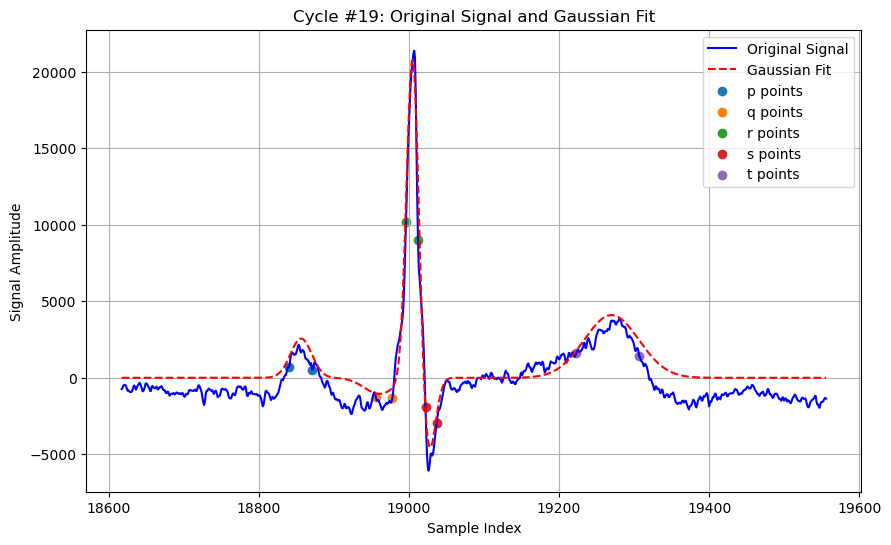

In [28]:
##Checking cycles 

cycle = 19

# If you've stored the original signal and fitting results in a DataFrame or similar structure, retrieve them
# For example, if `xs` and `sig` were stored or can be recalculated for cycle 39:
one_cycle = epochs_df.loc[epochs_df['cycle'] == cycle]
xs = np.arange(one_cycle['index'].iloc[0], one_cycle['index'].iloc[-1]+1)
sig = np.asarray(one_cycle['signal_y'])

# Assuming `fit` contains the fitted curve for cycle 39, which might have been stored or can be recalculated
# If you saved the fitting parameters per cycle, retrieve and use them to regenerate the fit curve
# Example: gaussian_params = ecg_output.loc[cycle, fitting_param_columns]
# fit = gaussian_function(xs, *gaussian_params)

# Now, plot the original signal and the fitted curve for cycle 39
plt.figure(figsize=(10, 6))
plt.plot(xs, sig, label='Original Signal', color='blue')
plt.plot(xs, fit, label='Gaussian Fit', color='red', linestyle='--')

# Assuming `ecg_output` is your DataFrame and it contains an 'r_squared' column
r_squared_value = ecg_output.loc[cycle, 'r_squared']

print(f'R-squared for cycle #{cycle}: {r_squared_value}')

# Marking components if needed; assuming you have markers for components (like R peaks, etc.)
# If you've extracted specific points (e.g., R peaks) and want to mark them:
for comp in ['p', 'q', 'r', 's', 't']:
    if comp+'_on' in ecg_output.columns and comp+'_off' in ecg_output.columns:
        on_point = ecg_output.loc[cycle, comp+'_on']
        off_point = ecg_output.loc[cycle, comp+'_off']
        plt.scatter([on_point, off_point], [sig[xs==on_point], sig[xs==off_point]], marker='o', label=f'{comp} points')

plt.title(f'Cycle #{cycle}: Original Signal and Gaussian Fit')
plt.xlabel('Sample Index')
plt.ylabel('Signal Amplitude')
plt.legend()
plt.grid(True)
plt.show()


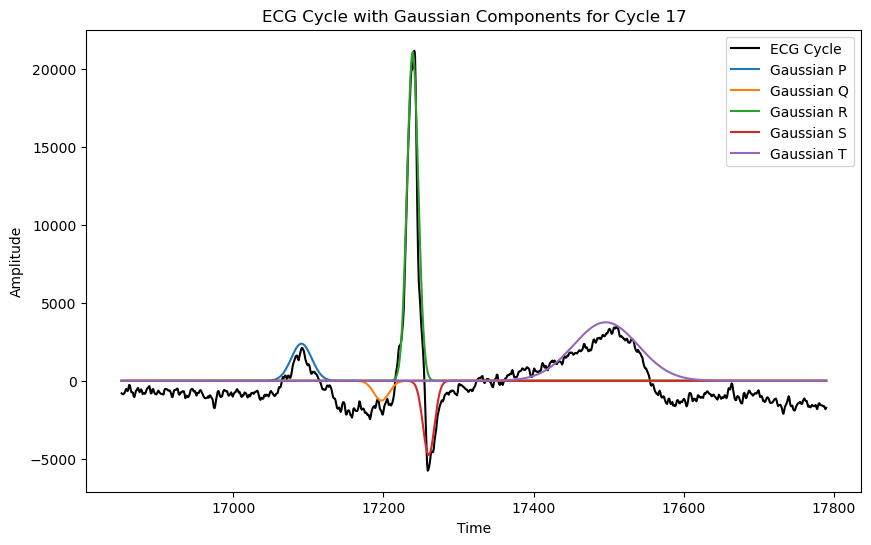

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Function to compute the Gaussian
def gaussian_function(x, mean, amplitude, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

# Choose a cycle to plot, for example, cycle 0
cycle_to_plot = 17

# Extract the xs and sig for the chosen cycle
one_cycle = epochs_df.loc[epochs_df['cycle'] == cycle_to_plot]
xs = np.arange(one_cycle['index'].iloc[0], one_cycle['index'].iloc[-1] + 1)
sig = np.asarray(one_cycle['signal_y'])

# Extract the Gaussian parameters for the chosen cycle
gaussian_params_reshape = np.array([
    [ecg_output_dict[f'{comp}_center'][cycle_to_plot],
     ecg_output_dict[f'{comp}_height'][cycle_to_plot],
     ecg_output_dict[f'{comp}_width'][cycle_to_plot]]
    for comp in ['p', 'q', 'r', 's', 't']
])

# Plot the ECG cycle
plt.figure(figsize=(10, 6))
plt.plot(xs, sig, label='ECG Cycle', color='black')

# Overlay each Gaussian component
for i, comp in enumerate(['p', 'q', 'r', 's', 't']):
    mean, amplitude, stddev = gaussian_params_reshape[i]
    gaussian = gaussian_function(xs, mean, amplitude, stddev)
    plt.plot(xs, gaussian, label=f'Gaussian {comp.upper()}')

plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title(f'ECG Cycle with Gaussian Components for Cycle {cycle_to_plot}')
plt.legend()
plt.show()


## Skewed Gaus

In [ ]:
def gaussian_function(xs, *params):
    """Gaussian fitting function.
    Parameters
    ----------
    xs : 1d array
        Input x-axis values.
    *params : float
        Parameters that define gaussian function.
    Returns
    -------
    ys : 1d array
        Output values for gaussian function.
    """

    ys = np.zeros_like(xs)
    min_width = 1e-10  # Set a small minimum value for width to avoid division by zero

    for ii in range(0, len(params), 3):
        ctr, hgt, wid = params[ii : ii + 3]
        wid = max(wid, min_width)  # Ensure width is not zero
        ys = ys + hgt * np.exp(-((xs - ctr) ** 2) / (2 * wid**2))

    return ys

def skewed_gaussian_function(xs, *params):
    """Skewed gaussian fitting function.
    ***This function is borrowed from https://github.com/fooof-tools/fooof/commit/cfa8a2bec08dab742e9556f4aeee1698415d40ba***
    Parameters
    ----------
    xs : 1d array
        Input x-axis values.
    *params : float
        Parameters that define the skewed gaussian function (center, height, width, alpha).
    Returns
    -------
    ys : 1d array
        Output values for skewed gaussian function.
    """

    ys = np.zeros_like(xs)
    for ii in range(0, len(params), 4):
        ctr, hgt, wid, alpha = params[ii : ii + 4]
        # Gaussian distribution
        ys = ys + gaussian_function(
            xs, ctr, hgt, wid
        )  # SUM of gaussians because we are fitting many at once
        # Skewed cumulative distribution function
        cdf = norm.cdf(alpha * ((xs - ctr) / wid))
        # Skew the gaussian
        ys = ys * cdf
        # Rescale height
        ys = (ys / np.max(ys)) * hgt
    return ys

In [ ]:
# Number of unique cycles
num_cycles = len(epochs_df['cycle'].unique())

ecg_output_dict = {
    "cycle": np.arange(0, num_cycles).tolist(),
    "p_center": [np.nan] * num_cycles,
    "p_height": [np.nan] * num_cycles,
    "p_width": [np.nan] * num_cycles,
    "q_center": [np.nan] * num_cycles,
    "q_height": [np.nan] * num_cycles,
    "q_width": [np.nan] * num_cycles,
    "r_center": [np.nan] * num_cycles,
    "r_height": [np.nan] * num_cycles,
    "r_width": [np.nan] * num_cycles,
    "s_center": [np.nan] * num_cycles,
    "s_height": [np.nan] * num_cycles,
    "s_width": [np.nan] * num_cycles,
    "t_center": [np.nan] * num_cycles,
    "t_height": [np.nan] * num_cycles,
    "t_width": [np.nan] * num_cycles,
    "r_squared": [np.nan] * num_cycles,
    "pr_interval": [np.nan] * num_cycles,
    "pr_segment": [np.nan] * num_cycles,
    "qrs_duration": [np.nan] * num_cycles,
    "st_segment": [np.nan] * num_cycles,
    "qt_interval": [np.nan] * num_cycles,
    "p_duration": [np.nan] * num_cycles,
    "pp_interval": [np.nan] * num_cycles,
    "rr_interval": [np.nan] * num_cycles,
    "fwhm_p": [np.nan] * num_cycles,
    "rise_time_p": [np.nan] * num_cycles,
    "decay_time_p": [np.nan] * num_cycles,
    "rise_decay_symmetry_p": [np.nan] * num_cycles,
    "sharpness_deriv_p": [np.nan] * num_cycles,
    "sharpness_diff_p": [np.nan] * num_cycles,
    "fwhm_q": [np.nan] * num_cycles,
    "rise_time_q": [np.nan] * num_cycles,
    "decay_time_q": [np.nan] * num_cycles,
    "rise_decay_symmetry_q": [np.nan] * num_cycles,
    "sharpness_deriv_q": [np.nan] * num_cycles,
    "sharpness_diff_q": [np.nan] * num_cycles,
    "fwhm_r": [np.nan] * num_cycles,
    "rise_time_r": [np.nan] * num_cycles,
    "decay_time_r": [np.nan] * num_cycles,
    "rise_decay_symmetry_r": [np.nan] * num_cycles,
    "sharpness_deriv_r": [np.nan] * num_cycles,
    "sharpness_diff_r": [np.nan] * num_cycles,
    "fwhm_s": [np.nan] * num_cycles,
    "rise_time_s": [np.nan] * num_cycles,
    "decay_time_s": [np.nan] * num_cycles,
    "rise_decay_symmetry_s": [np.nan] * num_cycles,
    "sharpness_deriv_s": [np.nan] * num_cycles,
    "sharpness_diff_s": [np.nan] * num_cycles,
    "fwhm_t": [np.nan] * num_cycles,
    "rise_time_t": [np.nan] * num_cycles,
    "decay_time_t": [np.nan] * num_cycles,
    "rise_decay_symmetry_t": [np.nan] * num_cycles,
    "sharpness_deriv_t": [np.nan] * num_cycles,
    "sharpness_diff_t": [np.nan] * num_cycles,
    "Average_Heart_Rate": [np.nan] * num_cycles,
    "SDNN": [np.nan] * num_cycles,
    "RMSSD": [np.nan] * num_cycles,
    "NN50": [np.nan] * num_cycles,
}
# # # Display the dictionary
# ecg_output_dict

In [ ]:
# Initialize variables to hold the previous peaks' locations
previous_r_center = None
previous_p_center = None

# Ensure on and off keys are initialized
#used to calculate various durations and intervals for the ECG components
for comp in ['p', 'q', 'r', 's', 't']:
    ecg_output_dict[f'{comp}_on'] = [np.nan] * num_cycles
    ecg_output_dict[f'{comp}_off'] = [np.nan] * num_cycles

# Isolate one subject at a time and build a for loop for fitting gaussians
    #len(epochs_df['cycle'].unique())
for cycle in np.arange(0, 20):
    print(f"Parameterizing cycle #{cycle}.")
    one_cycle = epochs_df.loc[epochs_df['cycle'] == cycle]
    if one_cycle.empty:
        print(f'cycle #{cycle} is empty')
        continue
    if one_cycle['signal_y'].isnull().values.any():
        print(f'cycle #{cycle} has NaNs')
        continue

    # X values and Y values with offset correction
    xs = np.arange(one_cycle['index'].iloc[0], one_cycle['index'].iloc[-1] + 1)
    sig = np.asarray(one_cycle['signal_y'])
    sig_flat = detrend(sig)
    sig = sig_flat - np.mean(sig_flat[0:25])
    

### GUESSES START #####
    ##### Defining R guesses first #####
    r_ind = np.argmax(sig)
    r_height = sig[r_ind]
    r_center = xs[r_ind]

    half_r_height = 0.5 * r_height

    #F_P_B: Find the indices for the onset (left) and offset (right) of a peak in a signal, based on the peak's height.
    le_ind_r, ri_ind_r = find_peak_boundaries(sig, r_ind, peak_height=r_height)

    # Use estimate_fwhm to calculate the FWHM based on the left and right indices
    fwhm_r = estimate_fwhm(le_ind_r, ri_ind_r, r_ind)

    # Check if FWHM calculation was successful
    if fwhm_r is None:
        print(f"Cycle #{cycle} could not estimate FWHM.")
        continue

    # #### Now define rest of component guesses ####     
    # Finding P, Q, S, T components
  
    q_min_ind = int(r_ind - (FWHM_Q_IND * fwhm_r))
    q_ind, q_height, q_center = find_extremum(sig, xs, q_min_ind, r_ind, mode='min')

    p_ind, p_height, p_center = find_extremum(sig, xs, 0, q_ind, mode='max')

    s_max_ind = int(r_ind + (FWHM_S_IND * fwhm_r))
    s_ind, s_height, s_center = find_extremum(sig, xs, r_ind, s_max_ind, mode='min')

    t_ind, t_height, t_center = find_extremum(sig, xs, s_ind, len(sig), mode='max')

    # Organizing component information
    component_inds = {
        'p': [p_ind, p_height, p_center],
        'q': [q_ind, q_height, q_center],
        'r': [r_ind, r_height, r_center],  
        's': [s_ind, s_height, s_center],
        't': [t_ind, t_height, t_center]
    }
### GUESSES END #####


### FITTING START #####
    # Initialize matrix of guess parameters for gaussian fitting
    guess = np.empty([0, 4])

    # Skip cycle if any of the expected positive components are negative
    if component_inds['p'][1] < 0:
        print(f"cycle #{cycle}'s p component is negative")
        continue
    if component_inds['r'][1] < 0:
        print(f"cycle #{cycle}'s r component is negative")
        continue
    if component_inds['t'][1] < 0:
        print(f"cycle #{cycle}'s t component is negative")
        continue
    
    for comp, params in component_inds.items():
        # Directly use the find_peak_boundaries function with peak_height parameter
        onset, offset = find_peak_boundaries(sig, peak_index=params[0], peak_height=params[1])
        # Store the onset and offset values in the dictionary
        ecg_output_dict[f'{comp}_on'][cycle] = xs[onset] if onset is not None else np.nan
        ecg_output_dict[f'{comp}_off'][cycle] = xs[offset] if offset is not None else np.nan

        # Guess bandwidth procedure: estimate the width of the peak

        short_side = min(abs(params[0] - onset), abs(offset - params[0])) if onset is not None and offset is not None else 0
        fwhm = short_side * 2
        guess_std = compute_gauss_std(fwhm)
        alpha_guess = 0  # Initial guess for alpha (no skew)

        # Update guess array with the correct number of columns
        guess = np.vstack((guess, (params[2], params[1], guess_std, alpha_guess)))
        peak_gauss = skewed_gaussian_function(xs, params[2], params[1], guess_std, alpha_guess)

      
    # The lo_bound and hi_bound arrays in the code are used to define the lower and upper bounds for the parameters of the Gaussian function 
    # during the curve fitting process. These bounds are important to ensure that the optimization algorithm used in curve_fit stays within reasonable  limits for each parameter.
    
    #center [0], height [1], width[2]; P-T are 0-4
    gaus_lo_bound = [[guess[0][0] - 0.5 * guess[0][2], -np.inf, guess[0][2] - 2 * guess[0][2],  -1e-2],
                [guess[1][0] - 0.5 * guess[1][2], -np.inf, guess[1][2] - 2 * guess[1][2],  -1e-2], 
                [guess[2][0] - 0.5 * guess[2][2], -np.inf, guess[2][2] - 2 * guess[2][2],  -1e-2],
                [guess[3][0] - 0.5 * guess[3][2], -np.inf, guess[3][2] - 2 * guess[3][2],  -1e-2],
                [guess[4][0] - 0.5 * guess[4][2], -np.inf, guess[4][2] - 2 * guess[4][2],  -1e-2]]

    gaus_hi_bound = [[guess[0][0] + 0.5 * guess[0][2], np.inf, guess[0][2] + 2 * guess[0][2], 1e-2],
                [guess[1][0] + 0.5 * guess[1][2], np.inf, guess[1][2] + 2 * guess[1][2], 1e-2], 
                [guess[2][0] + 0.5 * guess[2][2], np.inf, guess[2][2] + 2 * guess[2][2], 1e-2],
                [guess[3][0] + 0.5 * guess[3][2], np.inf, guess[3][2] + 2 * guess[3][2], 1e-2],
                [guess[4][0] + 0.5 * guess[4][2], np.inf, guess[4][2] + 2 * guess[4][2], 1e-2]]
    

    gaus_param_bounds = (tuple([item for sublist in gaus_lo_bound for item in sublist]),
                         tuple([item for sublist in gaus_hi_bound for item in sublist]))
    
    # Flatten guess, for use with curve fit
    guess_flat = np.ndarray.flatten(guess)

    maxfev = 5000

    # Check if any lower bound is not strictly less than its corresponding upper bound
    skip_cycle = False
    for lb, ub in zip(gaus_lo_bound, gaus_hi_bound):
        if not all(l < u for l, u in zip(lb, ub)):
            print(f"Skipping cycle #{cycle} due to invalid bounds.")
            skip_cycle = True
            break
    if skip_cycle:
        continue
    # If the check passes, proceed with fitting
    try:
        gaussian_params, _ = curve_fit(skewed_gaussian_function, xs, sig,
                                       p0=guess_flat, maxfev=maxfev, bounds=gaus_param_bounds)
        # Assuming the rest of your code for fitting and plotting remains unchanged
    except RuntimeError as e:
        print(f"Could not fit cycle #{cycle}: {e}")
        continue

    # Reshape gaussian_params from 1,15 to 3, 5 to feed into create peak params
    gaussian_params_reshape = gaussian_params.reshape((5, 3))
    
    # Store the center, height, and width for each peak in the dictionary
    for i, comp in enumerate(['p', 'q', 'r', 's', 't']):
        ecg_output_dict[f'{comp}_center'][cycle] = gaussian_params_reshape[i, 0]
        ecg_output_dict[f'{comp}_height'][cycle] = gaussian_params_reshape[i, 1]
        ecg_output_dict[f'{comp}_width'][cycle] = gaussian_params_reshape[i, 2]


    ## Bycycle fit
    peak_params = create_peak_params(xs, sig, gaussian_params_reshape)


    # initialize list of shape parameters
    shape_params = np.empty((len(peak_params), 6))
    peak_indices = np.empty((len(peak_params), 3))

    for ii, peak in enumerate(peak_params):
        # get peak indices
        start_index, peak_index, end_index = get_peak_indices(xs, sig, peak)

        # if the peak indices could not be determined, set all shape params to NaN
        if np.isnan(start_index) or np.isnan(end_index):
            shape_params[ii] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
            peak_indices[ii] = [np.nan, np.nan, np.nan]
            continue

        # compute fwhm, rise-, and decay-time
        fwhm = xs[end_index] - xs[start_index]
        rise_time = xs[peak_index] - xs[start_index]
        decay_time = xs[end_index] - xs[peak_index]
        

        # compute rise-decay symmetry
        rise_decay_symmetry = rise_time / fwhm

        ######SHARPNESS######
        # Compute sharpness using diff
        half_mag = int(np.abs(peak[1] / 2)) # peak[1] represents the height of the peak
        half_mag_cropped_xval = np.argmin(np.abs(sig - half_mag))
        left_index  = peak_index - 15
        right_index = peak_index + 15

        sharpness_diff = np.mean(
            (sig[peak_index] - sig[left_index], sig[peak_index] + sig[right_index])) # peak[0] refers to the center (or index) of a peak in a signal, often derived from the Gaussian parameters obtained from curve fitting. 
        sharpness_diff = np.abs(sharpness_diff)

        # Compute sharpness using the derivative method
        sharpness_deriv = calculate_sharpness_deriv(sig, peak_index) / (sig[peak_index])  #normalizing by amplitude
        sharpness_deriv = np.abs(sharpness_deriv)

        # Collect results
        shape_params[ii] = [fwhm, rise_time, decay_time, rise_decay_symmetry,
                            sharpness_diff, sharpness_deriv]
        peak_indices[ii] = [start_index, peak_index, end_index]

    fit = skewed_gaussian_function(xs, *gaussian_params)

    # Calculate durations and intervals
    ecg_output_dict['p_duration'][cycle] = ecg_output_dict['p_off'][cycle] - ecg_output_dict['p_on'][cycle]
    ecg_output_dict['pr_interval'][cycle] = ecg_output_dict['q_on'][cycle] - ecg_output_dict['p_on'][cycle]
    ecg_output_dict['pr_segment'][cycle] = ecg_output_dict['q_on'][cycle] - ecg_output_dict['p_off'][cycle]
    ecg_output_dict['qrs_duration'][cycle] = ecg_output_dict['s_off'][cycle] - ecg_output_dict['q_on'][cycle]
    ecg_output_dict['st_segment'][cycle] = ecg_output_dict['t_off'][cycle] - ecg_output_dict['s_off'][cycle]
    ecg_output_dict['qt_interval'][cycle] = ecg_output_dict['t_off'][cycle] - ecg_output_dict['q_on'][cycle]

    # Calculate R-R interval if there's a previous R peak
    if previous_r_center is not None:
        r_r_interval = r_center - previous_r_center
        # Assign R-R interval to the dictionary
        ecg_output_dict['rr_interval'][cycle] = r_r_interval
    else:
        # Assign NaN for the first cycle or if previous R peak is missing
        ecg_output_dict['rr_interval'][cycle] = np.nan

    # Calculate P-P interval if there's a previous P peak
    if previous_p_center is not None:
        p_p_interval = p_center - previous_p_center
        # Assign P-P interval to the dictionary
        ecg_output_dict['pp_interval'][cycle] = p_p_interval
    else:
        # Assign NaN for the first cycle or if previous P peak is missing
        ecg_output_dict['pp_interval'][cycle] = np.nan

    # Update the previous peaks' locations
    previous_r_center = r_center
    previous_p_center = p_center

    r_squared = calc_r_squared(sig, fit)

    # Add features to dictionary
    ecg_output_dict['r_squared'][cycle] = r_squared
    
    shape_params_flat = np.ndarray.flatten(shape_params)
    ecg_output_dict['fwhm_p'][cycle], ecg_output_dict['rise_time_p'][cycle], ecg_output_dict['decay_time_p'][cycle], \
    ecg_output_dict['rise_decay_symmetry_p'][cycle], ecg_output_dict['sharpness_diff_p'][cycle], ecg_output_dict['sharpness_deriv_p'][cycle] = shape_params_flat[:6]
    ecg_output_dict['fwhm_q'][cycle], ecg_output_dict['rise_time_q'][cycle], ecg_output_dict['decay_time_q'][cycle], \
    ecg_output_dict['rise_decay_symmetry_q'][cycle], ecg_output_dict['sharpness_diff_q'][cycle], ecg_output_dict['sharpness_deriv_q'][cycle] = shape_params_flat[6:12]
    ecg_output_dict['fwhm_r'][cycle], ecg_output_dict['rise_time_r'][cycle], ecg_output_dict['decay_time_r'][cycle], \
    ecg_output_dict['rise_decay_symmetry_r'][cycle], ecg_output_dict['sharpness_diff_r'][cycle], ecg_output_dict['sharpness_deriv_r'][cycle] = shape_params_flat[12:18]
    ecg_output_dict['fwhm_s'][cycle], ecg_output_dict['rise_time_s'][cycle], ecg_output_dict['decay_time_s'][cycle], \
    ecg_output_dict['rise_decay_symmetry_s'][cycle], ecg_output_dict['sharpness_diff_s'][cycle], ecg_output_dict['sharpness_deriv_s'][cycle] = shape_params_flat[18:24]
    ecg_output_dict['fwhm_t'][cycle], ecg_output_dict['rise_time_t'][cycle], ecg_output_dict['decay_time_t'][cycle], \
    ecg_output_dict['rise_decay_symmetry_t'][cycle], ecg_output_dict['sharpness_diff_t'][cycle], ecg_output_dict['sharpness_deriv_t'][cycle] = shape_params_flat[24:30]


# # Process the raw ECG signal (not the cleaned signal)
# processed_data, _ = nk.ecg_process(ecg_notch, sampling_rate=1000)

# # Access heart rate from the processed data
# heart_rate = processed_data['ECG_Rate']

# # Calculate average heart rate
# average_heart_rate = heart_rate.mean()

# rr_intervals = np.array(ecg_output_dict['rr_interval'])
# rr_intervals = rr_intervals[~np.isnan(rr_intervals)]  # Ensure no NaN values

# # Calculate HRV metrics
# if len(rr_intervals) > 1:  # Need at least two intervals for RMSSD
#     sdnn = np.std(rr_intervals, ddof=1)
#     diff_nn_intervals = np.diff(rr_intervals)
#     squared_diff_nn_intervals = diff_nn_intervals ** 2
#     rmssd = np.sqrt(np.mean(squared_diff_nn_intervals))
#     nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 50)
# else:
#     sdnn, rmssd, nn50 = np.nan, np.nan, np.nan

# # Add the calculated values to the dictionary for the first cycle
# ecg_output_dict['Average_Heart_Rate'][0] = average_heart_rate
# ecg_output_dict['SDNN'][0] = sdnn
# ecg_output_dict['RMSSD'][0] = rmssd
# ecg_output_dict['NN50'][0] = nn50

# Convert dictionary to DataFrame
ecg_output = pd.DataFrame(ecg_output_dict)

# # Save output in new file
# ecg_output.to_csv(f'../docs/saved_files/timedomain_results/{SUB_NUM}_ecg_output.csv')



#### Checking individual cycles

R-squared for cycle #19: 0.9379396134976719


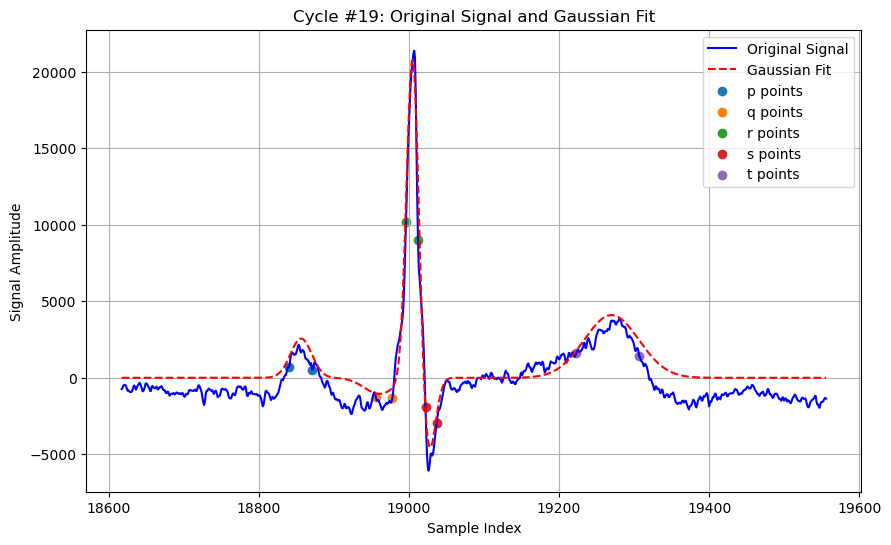

In [27]:
##Checking cycles 

cycle = 19

# If you've stored the original signal and fitting results in a DataFrame or similar structure, retrieve them
# For example, if `xs` and `sig` were stored or can be recalculated for cycle 39:
one_cycle = epochs_df.loc[epochs_df['cycle'] == cycle]
xs = np.arange(one_cycle['index'].iloc[0], one_cycle['index'].iloc[-1]+1)
sig = np.asarray(one_cycle['signal_y'])

# Assuming `fit` contains the fitted curve for cycle 39, which might have been stored or can be recalculated
# If you saved the fitting parameters per cycle, retrieve and use them to regenerate the fit curve
# Example: gaussian_params = ecg_output.loc[cycle, fitting_param_columns]
# fit = gaussian_function(xs, *gaussian_params)

# Now, plot the original signal and the fitted curve for cycle 39
plt.figure(figsize=(10, 6))
plt.plot(xs, sig, label='Original Signal', color='blue')
plt.plot(xs, fit, label='Gaussian Fit', color='red', linestyle='--')

# Assuming `ecg_output` is your DataFrame and it contains an 'r_squared' column
r_squared_value = ecg_output.loc[cycle, 'r_squared']

print(f'R-squared for cycle #{cycle}: {r_squared_value}')

# Marking components if needed; assuming you have markers for components (like R peaks, etc.)
# If you've extracted specific points (e.g., R peaks) and want to mark them:
for comp in ['p', 'q', 'r', 's', 't']:
    if comp+'_on' in ecg_output.columns and comp+'_off' in ecg_output.columns:
        on_point = ecg_output.loc[cycle, comp+'_on']
        off_point = ecg_output.loc[cycle, comp+'_off']
        plt.scatter([on_point, off_point], [sig[xs==on_point], sig[xs==off_point]], marker='o', label=f'{comp} points')

plt.title(f'Cycle #{cycle}: Original Signal and Gaussian Fit')
plt.xlabel('Sample Index')
plt.ylabel('Signal Amplitude')
plt.legend()
plt.grid(True)
plt.show()


#### Testing scaling the deriv by the amplitude

R-squared for cycle #19: 0.9721829620325186


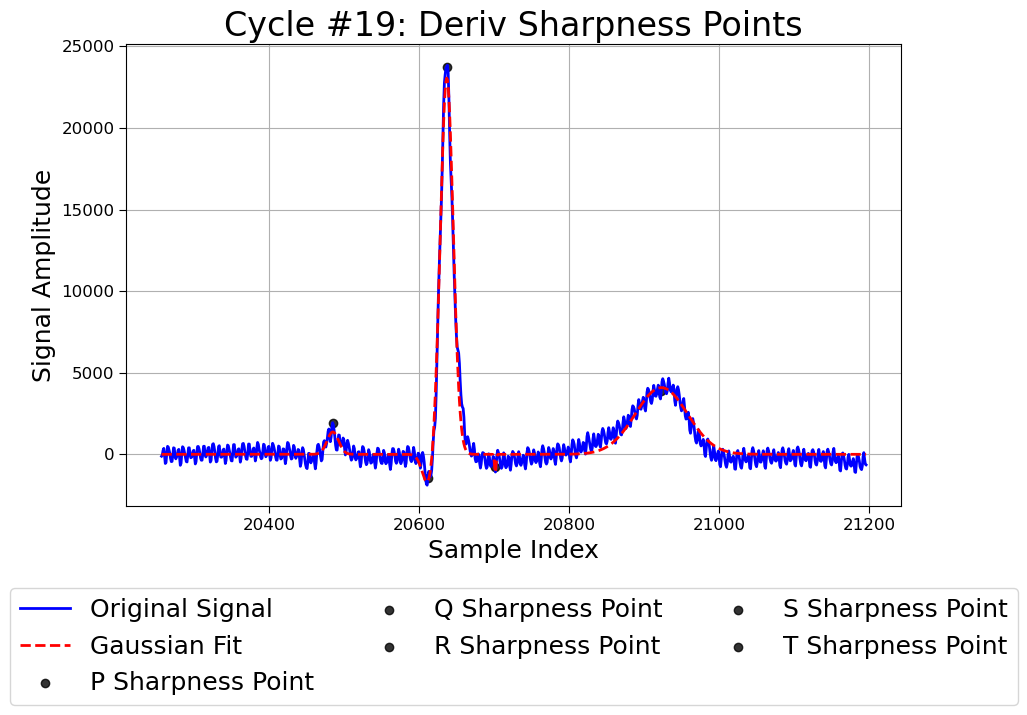


Sharpness Values:
  Peak  Sharpness Deriv
0    P         0.146893
1    Q        -0.424323
2    R         0.054853
3    S        -0.352529
4    T         0.067910


In [ ]:
# # import numpy as np
# # import pandas as pd
# # import matplotlib.pyplot as plt
# # from scipy.signal import detrend

# ##############
# # Define the sharpness calculation function using the derivative, normalized by peak amplitude
# # Define your cycle of interest
# cycle = 19

# # Retrieve the original signal for the cycle
# one_cycle = epochs_df.loc[epochs_df['cycle'] == cycle]
# xs = np.arange(one_cycle['index'].iloc[0], one_cycle['index'].iloc[-1] + 1)
# sig = np.asarray(one_cycle['signal_y'])

# # Detrend and mean-adjust the signal
# sig_flat = detrend(sig)
# sig = sig_flat - np.mean(sig_flat[0:25])

# # Retrieve the Gaussian fit parameters for the cycle
# # Assuming the fit parameters are stored in `ecg_output` for the specific cycle
# gaussian_params = ecg_output.iloc[cycle, 1:16].values  # Adjust based on your storage format
# fit = gaussian_function(xs, *gaussian_params)

# # Calculate sharpness for each peak
# sharpness_results = {}
# local_peak_indices = {}  # Store local peak indices for plotting

# # Get peak indices
# peaks = ['p', 'q', 'r', 's', 't']

# # Create a list of local peak indices for each peak ('p', 'q', 'r', 's', 't') in the specified cycle
# # This list comprehension iterates over each peak in the list `peaks`
#     # Access the peak center value from `ecg_output` DataFrame for the given cycle and peak
#     # Retrieve the first index of the cycle from the `one_cycle` DataFrame to adjust the peak index to a local index
#     # Iterate over each peak in the list `peaks`

# peak_indices = [int(ecg_output.loc[cycle, f'{peak}_center']) - one_cycle['index'].iloc[0] for peak in peaks]

# for peak in peaks:
#     global_peak_index = int(ecg_output.loc[cycle, f'{peak}_center'])
    
#     # Adjust the peak index to be relative to the cycle
#     local_peak_index = global_peak_index - one_cycle['index'].iloc[0]
    
#     # Ensure local_peak_index is within bounds
#     if local_peak_index < 0 or local_peak_index >= len(sig):
#         print(f"Skipping {peak} peak: index {local_peak_index} out of bounds for cycle {cycle}")
#         continue
    
#     # Retrieve the amplitude of the peak
#     peak_amplitude = sig[local_peak_index]
#     # Calculate the sharpness derivative and normalize it by the peak amplitude
#     sharpness_deriv = calculate_sharpness_deriv(sig, local_peak_index) / peak_amplitude
#     sharpness_results[peak] = sharpness_deriv
#     local_peak_indices[peak] = local_peak_index  # Save local peak index

# # Plot the original signal and the Gaussian fit
# plt.figure(figsize=(10, 6))
# plt.plot(xs, sig, label='Original Signal', color='blue')
# plt.plot(xs, fit, label='Gaussian Fit', color='red', linestyle='--')

# # Mark the sharpness calculation points with darker color
# for peak, local_peak_index in local_peak_indices.items():
#     plt.scatter(xs[local_peak_index], sig[local_peak_index], label=f'{peak.upper()} Sharpness Point', color='black', alpha=0.8)

# # Display R-squared value for the fit
# r_squared_value = ecg_output.loc[cycle, 'r_squared']
# print(f'R-squared for cycle #{cycle}: {r_squared_value}')

# plt.title(f'Cycle #{cycle}: Deriv Sharpness Points')
# plt.xlabel('Sample Index')
# plt.ylabel('Signal Amplitude')
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
# plt.grid(True)
# plt.show()

# # Print the sharpness values in a table
# sharpness_table = pd.DataFrame({
#     'Peak': [peak.upper() for peak in sharpness_results.keys()],
#     'Sharpness Deriv': [sharpness for sharpness in sharpness_results.values()]
# })

# print("\nSharpness Values:")
# print(sharpness_table)


### HRV 

In [26]:
####### #### ####  Heart Rate and Avg HR  #### #### #### #### 

# Process the raw ECG signal (not the cleaned signal)
processed_data, _ = nk.ecg_process(ecg_notch, sampling_rate=1000)

# Access heart rate from the processed data
heart_rate = processed_data['ECG_Rate']

# Calculate average heart rate
average_heart_rate = heart_rate.mean()

print("Average Heart Rate:", average_heart_rate)


#########################

#########################

rr_intervals = (ecg_output['rr_interval'])
rr_intervals = rr_intervals[~np.isnan(rr_intervals)]  # Ensure no NaN values

# Calculate HRV metrics
if len(rr_intervals) > 1:  # Need at least two intervals for RMSSD
    sdnn = np.std(rr_intervals, ddof=1)
    diff_nn_intervals = np.diff(rr_intervals)
    squared_diff_nn_intervals = diff_nn_intervals ** 2
    rmssd = np.sqrt(np.mean(squared_diff_nn_intervals))
    nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 50)

    
#     print(f"SDNN: {sdnn:.2f} ms")
#     print(f"RMSSD: {rmssd:.2f} ms")
# else:
#     print("Not enough data for HRV calculations.")


# Add the calculated values to the first row
ecg_output.loc[0, 'Average_Heart_Rate'] = average_heart_rate
ecg_output.loc[0, 'SDNN'] = sdnn if len(rr_intervals) > 1 else np.nan
ecg_output.loc[0, 'RMSSD'] = rmssd if len(rr_intervals) > 1 else np.nan
ecg_output.loc[0, 'NN50'] = nn50 if len(rr_intervals) > 1 else np.nan

# Ensure the rest of the rows for these columns are filled with NaN
# This step is crucial if your DataFrame already has more than one row when you add these new columns.
if len(ecg_output) > 1:
    ecg_output.loc[1:, ['Average_Heart_Rate', 'SDNN', 'RMSSD']] = np.nan

print(ecg_output.head())  # Just printing the first few rows for verification

Average Heart Rate: 70.84134414346538
   cycle     p_center     p_height    p_width     q_center     q_height  \
0      0          NaN          NaN        NaN          NaN          NaN   
1      1  1614.742564  2761.233584  19.154466  1735.150678 -1127.510596   
2      2  2442.963319  3119.094036  20.390428  2546.876695 -1307.072903   
3      3  3213.194280  4180.121637  22.607921  3316.876695  -532.147894   
4      4  4689.794574  3896.061736  25.556965  4814.261188  -347.363158   

     q_width     r_center      r_height   r_width  ...    p_on   p_off  \
0        NaN          NaN           NaN       NaN  ...     NaN     NaN   
1   2.068441  1762.876695  21056.136825  7.829037  ...  1597.0  1640.0   
2  12.739827  2589.625554  21757.947298  7.484075  ...  2413.0  2471.0   
3   7.629276  3359.529776  21233.491537  7.374813  ...  3196.0  3238.0   
4   1.037772  4843.876695  20800.722453  7.416751  ...  4667.0  4719.0   

     q_on   q_off    r_on   r_off    s_on   s_off    t_on   t_off 

# Visualize Waveform Shape Features

ValueError: need at least one array to concatenate

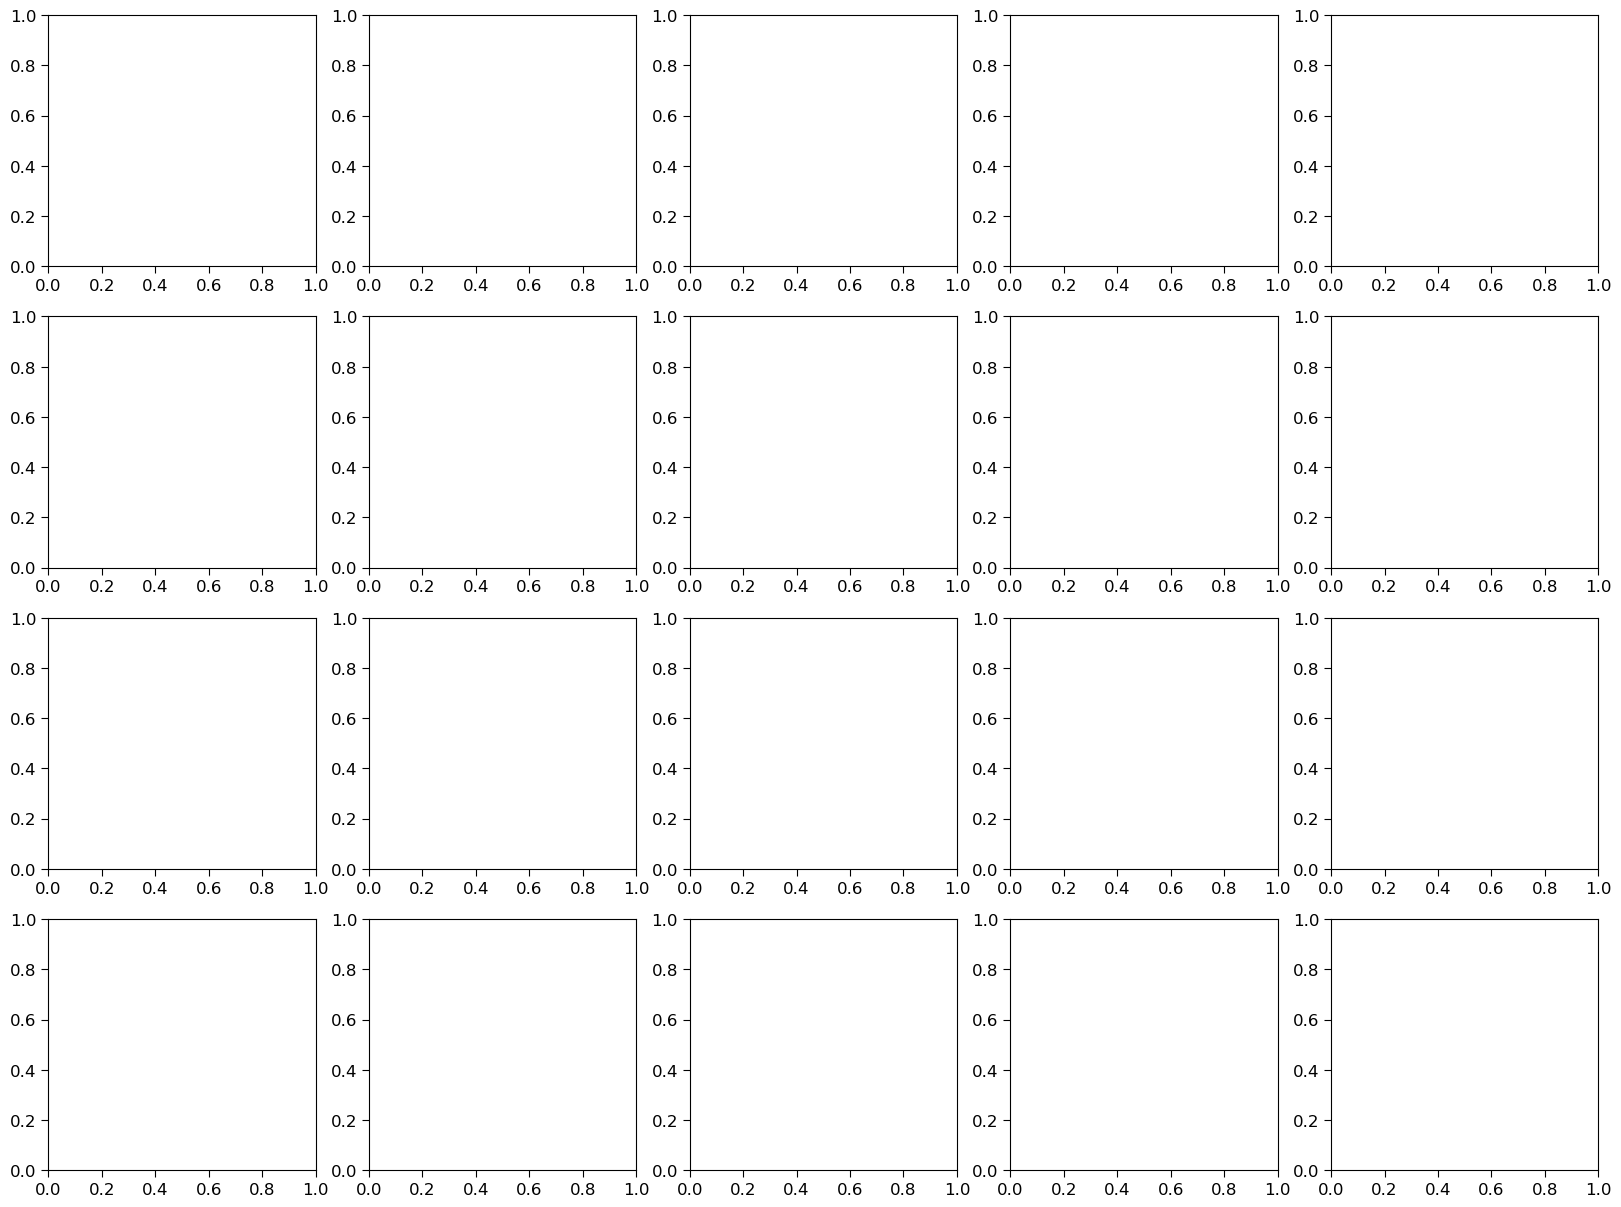

In [ ]:
# ## Clean first so there are no Nans
# cleaned_ecg_output = ecg_output[:].dropna()

# ecg_feature_hist = generate_histograms(cleaned_ecg_output, cycle_column='cycle')

# # Define the path where the file will be saved
# hist_path = f'../docs/figures/{SUB_NUM}_timedomain_feat_hist.png'

# # Save the figure using the figure object returned by the function
# ecg_feature_hist.savefig(hist_path)


## Autocorrelations 

Plot the autocorrelations of each feature

In [ ]:
## Clean first so there are no Nans
cleaned_ecg_output = ecg_output[:].dropna()

#### ACF plots

In [ ]:
# # Autocorrelation
# from statsmodels.tsa.stattools import acf as acf
# NLAGS = 100

# #### Height 
# fig = plt.gcf()

# for col in ecg_output.columns:
#     if 'height' in col:
#         plt.plot(np.arange(0,(NLAGS+1)), acf(ecg_output[col], nlags=NLAGS), 
#                  label=col)

# plt.legend()
# plt.title(f'Participant {SUB_NUM}: Component Height ACF')
# plt.show()

# ## Width 
# fig = plt.gcf()
# for col in ecg_output.columns:
#     if 'width' in col:
#         plt.plot(np.arange(0,(NLAGS+1)), acf(ecg_output[col], nlags=NLAGS), 
#                  label=col)
# plt.legend()
# plt.title(f'Participant {SUB_NUM}: Component Width ACF')
# plt.show()

# #### Duration
# fig = plt.gcf()

# for col in ecg_output.columns:
#     if 'duration' in col:
#         plt.plot(np.arange(0,(NLAGS+1)), acf(ecg_output[col], nlags=NLAGS), 
#                  label=col)

# plt.legend()
# plt.title(f'Participant {SUB_NUM}: Component Duration ACF')
# plt.show()

# ### Intervals
# #cleaned_RR_interval, pr_invterval, qt_interval, pp_interval
# fig = plt.gcf()
# for col in ecg_output.columns:
#     if 'interval' in col:
#         plt.plot(np.arange(0,(NLAGS+1)), acf(ecg_output[col], nlags=NLAGS), 
#                  label=col)
# plt.legend()
# plt.title(f'Participant {SUB_NUM}: Component Interval ACF')
# plt.show()

# ### Segment
# fig = plt.gcf()
# for col in ecg_output.columns:
#     if 'segment' in col:
#         plt.plot(np.arange(0,(NLAGS+1)), acf(ecg_output[col], nlags=NLAGS), 
#                  label=col)
# plt.legend()
# plt.title(f'Participant {SUB_NUM}: Component Segment ACF')
# plt.xlabel('Lags')
# plt.ylabel('..')
# plt.show()

# # fig.savefig(f'../figures/{SUB_NUM}_acf_width.png', transparent=False)

### NEW ACF Fitting Method (from Ryan)

- When you run an Autocorrelation Function (ACF) analysis with 200 lags on a signal that is 5 minutes long, what you're analyzing is how the signal correlates with itself up to a 0.2-second offset. 

- The analysis is focused on identifying patterns of self-similarity within a window that extends 0.2 seconds into the past (relative to any given point in time).

In [ ]:
# Instantiate the ACF class
acf = ACF()

# Select all columns except the first one
features_to_analyze = cleaned_ecg_output.columns[1:60]

# Initialize an empty DataFrame to store the results
acf_results_df = pd.DataFrame(columns=['Feature', 'tau', 'height', 'offset'])

# Iterate over each feature and compute its ACF and fit parameters
for feature in features_to_analyze:
    try:
        #print(f"Processing feature: {feature}")  # Print the feature being processed
        

        # Assuming acf is correctly set up for each loop iteration
        acf.compute_acf(cleaned_ecg_output[feature], fs, nlags=200)
        #print(f"ACF computation done for {feature}")  # Indicate ACF computation is done

        acf.fit()
       # print(f"Fitting done for {feature}")  # Indicate fitting is done
    
        # Extract the fitted parameters
        tau, height, offset = acf.params[:3]
       # print(f"Parameters extracted for {feature}")  # Indicate parameters extraction is done
    
        # Create a temporary DataFrame for the current feature's results
        temp_df = pd.DataFrame({
            'Feature': [feature], 
            'tau': [tau], 
            'height': [height], 
            'offset': [offset]
        })
    
        # Use pd.concat to append the results to acf_results_df DataFrame
        acf_results_df = pd.concat([acf_results_df, temp_df], ignore_index=True)
        #print(f"Results appended for {feature}")  # Indicate successful appending of results

    except Exception as e:
        #print(f"Error processing feature {feature}: {e}")  # Print error message
        break  # Optionally break the loop or continue to the next iteration

# Now, compute ACF for the entire signal, 'sig'
acf.compute_acf(sig, fs, nlags=10)  # Assuming 'fs' is your sampling frequency
acf.fit()

# Extract the fitted parameters for the whole signal
tau_sig, height_sig, offset_sig = acf.params[:3]

# Add the whole signal's ACF analysis results to the DataFrame
temp_df_sig = pd.DataFrame({
    'Feature': ['Whole Signal'],  # Indicating this row is for the whole signal
    'tau': [tau_sig],
    'height': [height_sig],
    'offset': [offset_sig]
})

# Append the results to the acf_results_df DataFrame
acf_results = pd.concat([acf_results_df, temp_df_sig], ignore_index=True)

# #Save output in new file 
# acf_results.to_csv(f'../docs/saved_files/spectral_results/{SUB_NUM}_acf_results.csv')

/Users/morganfitzgerald/miniconda3/envs/ecgenv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:691: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


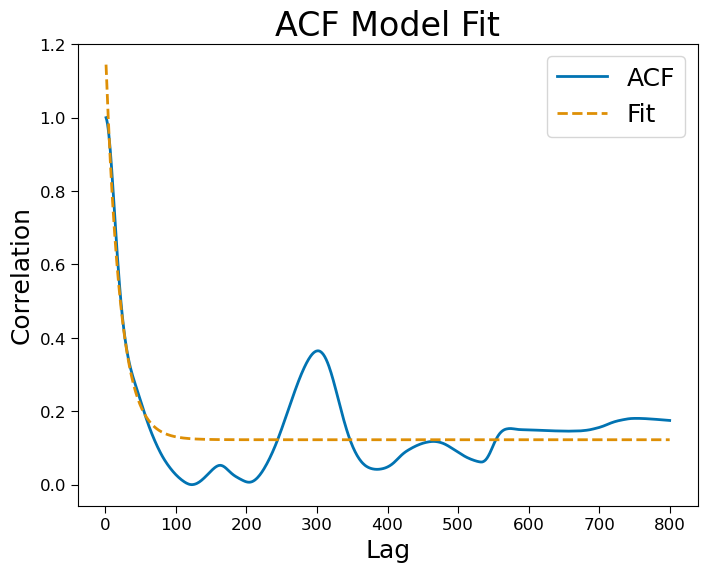

In [ ]:
# Fit whole sig
acf = ACF()
acf.compute_acf(sig, fs, nlags=800)
acf.fit(with_cos=False, n_jobs=-1)
acf.plot()

## Additional ECG Features (time domain)

In [ ]:

#Save output in new file 
# ecg_output.to_csv(f'../docs/saved_files/timedomain_results/{SUB_NUM}_ecg_output.csv')
